In [211]:
from datasets import load_dataset
import os
# import pytorch_lightning as py
import torch.utils.data as data
from torch.utils.data import DataLoader, ConcatDataset
import torch
import pandas as pd
import gzip
# import glob
import tarfile
from PIL import Image
import io
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
import piq
import random
import time

In [212]:
if torch.cuda.is_available():
    print(f"running cuda on device: {torch.cuda.current_device()}")
    device = torch.device("cuda")    
else:
    print(f"no cuda device found")
    device = torch.device("cpu")    


running cuda on device: 0


# Dataset

In [255]:
class DepthDataSet(data.Dataset):
    def __init__(self,images_path,depth_path,transform=None):
        self.image_path = images_path
        self.depth_path = depth_path
        self.transform = transform

        self.image_files = ([
            f for f in os.listdir(self.image_path)
            if os.path.isfile(os.path.join(self.image_path,f))
            ])
        self.depth_files = ([
            f for f in os.listdir(self.depth_path)
            if os.path.isfile(os.path.join(self.depth_path,f))
            ])

    def __len__(self):
        return len(self.depth_files)
    
    def __getitem__(self, index):
        image_file = self.image_files[index]
        depth_file = self.depth_files[index]
        
        img_path = os.path.join(self.image_path, image_file)
        dpth_path = os.path.join(self.depth_path, depth_file)


        image = Image.open(img_path)
        image = self.transform(image)


        mat_file = loadmat(dpth_path)
        depth = mat_file.get("Position3DGrid")
        depth = depth[:,:,3]
        depth = np.log1p(depth)

        depth = cv.resize(depth, (1704,2272), interpolation=cv.INTER_CUBIC)
        depth = cv.normalize(depth, None, 0, 255, cv.NORM_MINMAX)
        depth = depth.astype(np.uint8)

        depth = np.expand_dims(depth,axis=2)

        depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
        return image, depth

        

In [256]:
train_dataset = DepthDataSet(images_path='./data/train/imgs',depth_path='./data/train/depths',transform=transforms.ToTensor())
val_dataset = DepthDataSet(images_path='./data/test/imgs',depth_path='./data/test/depths',transform=transforms.ToTensor())

In [257]:
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=8,shuffle=True)

In [258]:
from datasets import load_dataset

nyu_depth_dataset = load_dataset("sayakpaul/nyu_depth_v2",trust_remote_code=True)

Loading dataset shards:   0%|          | 0/127 [00:00<?, ?it/s]

In [259]:
def colored_depthmap(depth, d_min=None, d_max=None):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * plt.cm.viridis(depth_relative)[:,:,:3]

def show_depthmap(depth_map):
   if not isinstance(depth_map, np.ndarray):
       depth_map = np.array(depth_map)
   if depth_map.ndim == 3:
       depth_map = depth_map.squeeze()

   d_min = np.min(depth_map)
   d_max = np.max(depth_map)
   depth_map = colored_depthmap(depth_map, d_min, d_max)

   plt.imshow(depth_map.astype("uint8"))
   plt.axis("off")
   plt.show()


In [260]:
class NyuDataset(data.Dataset):
    def __init__(self,dataset,tranform_image=None,transform_depth=None):
        self.dataset = dataset
        self.transform_image = tranform_image
        self.transform_depth = transform_depth

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image = self.dataset[index]['image']
        depth = self.dataset[index]['depth_map']
        image = image.resize((1704,2272),3)
        depth = depth.resize((1704,2272),3)
        
        
        d_min = np.min(depth)
        d_max = np.max(depth)

        depth_relative = (depth - d_min) / (d_max - d_min)
        depth =  255 * depth_relative
        depth = depth.astype("uint8")

        
        transform = transforms.ToTensor()
        image = transform(image)
        depth = transform(depth)
        

        if self.transform_image:
            image = self.transform_image(image)
        
        if self.transform_depth:
            depth = self.transform_depth(depth)

        depth = depth.mean(axis=0).unsqueeze(0) 
        return image, depth

In [261]:
random_frames_indices =  np.random.choice(len(nyu_depth_dataset["train"]),400).tolist()
train_sub_dataset = nyu_depth_dataset["train"].select(random_frames_indices)

#resizing

train_nyu_dataset = NyuDataset(train_sub_dataset)

train_nyu_dataloader = DataLoader(train_nyu_dataset,batch_size=8,shuffle=True)


In [262]:
random_frames_indices =  np.random.choice(len(nyu_depth_dataset["validation"]),400).tolist()
test_sub_dataset = nyu_depth_dataset["validation"].select(random_frames_indices)

test_nyu_dataset = NyuDataset(train_sub_dataset)

test_nyu_dataloader = DataLoader(train_nyu_dataset,batch_size=8,shuffle=True)


In [263]:
concat_dataset = ConcatDataset([train_dataset,train_nyu_dataset])
concat_train_dataloader = DataLoader(concat_dataset, batch_size=8, shuffle=True)

## Testing dataset

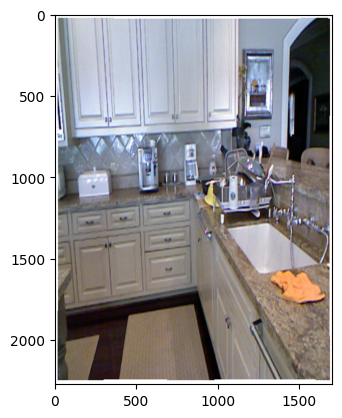

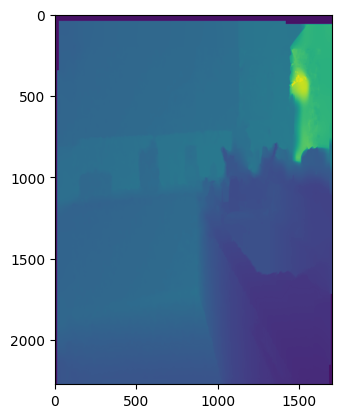

torch.Size([1, 2272, 1704])


In [264]:
image,depth = train_nyu_dataset[5]
np.shape(image)
plt.imshow(image.permute(1,2,0))
plt.show()
plt.imshow(depth.permute(1,2,0))
plt.show()
print(np.shape(depth))

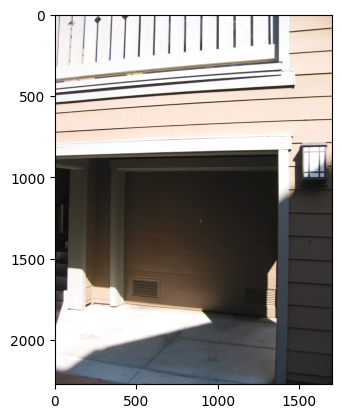

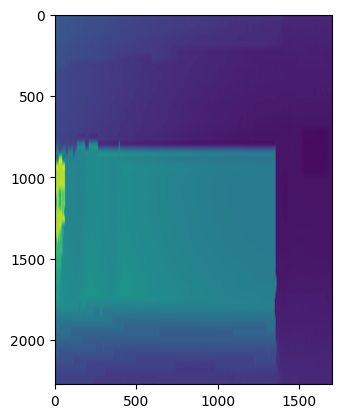

In [265]:
index=47
image,depth = train_dataset[index]
image = image.cpu().permute(1,2,0).numpy()
plt.imshow(image)
plt.show()

depth = depth.cpu().permute(1,2,0).numpy()
plt.imshow(depth)
plt.show()

# Image manipulation

In [266]:
def equalizeDepth(depth):
    depth = depth.cpu().permute(1,2,0).numpy()
    depth = ((depth-depth.min()) / (depth.max()-depth.min())) * 255
    depth = depth.astype(np.uint8)
    depth = cv.equalizeHist(depth)

    depth = np.expand_dims(depth, axis=0)

    depth = torch.tensor(depth)
    depth = depth.float()/255.0

    return depth

In [267]:
def fourierTransform(image, amount=20):
    b,g,r = image[:,:,0],image[:,:,1],image[:,:,2]
    def channelFourier(channel):
        image_transformed = np.fft.fft2(channel)
        transformed_shifted = np.fft.fftshift(image_transformed)
        # print(np.shape(transformed_shifted))
        (rows, cols) = transformed_shifted.shape
        crow, ccol = rows//2,cols//2

        area = amount
        mask = np.ones((rows,cols),np.uint8)
        mask[crow-area:crow+area, ccol-area:ccol+area] = 0
        transformed_shifted_filtered = transformed_shifted * mask
        # plt.imshow(20 * np.log(np.abs(transformed_shifted_filtered)))
        # plt.show()

        shift_back = np.fft.ifftshift(transformed_shifted_filtered)
        channel = np.fft.ifft2(shift_back)
        channel = np.abs(channel)
        channel = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

        return channel
    
    b = channelFourier(b)
    g = channelFourier(g)
    r = channelFourier(r)

    image = np.dstack((b,g,r))
    return image

In [268]:
def equalizeImage(image,fourier_amount=20):
    image = image.cpu().permute(1,2,0).numpy()

    gamma = .6
    image = np.power(image,gamma)

    # image = image*255
    image = ((image-image.min()) / (image.max()-image.min())) * 255

    # image = (image-np.mean(image)) - np.std(image)

    image = image.astype(np.uint8)

    
    b,g,r = cv.split(image)
    b_eq = cv.equalizeHist(b)
    g_eq = cv.equalizeHist(g)
    r_eq = cv.equalizeHist(r)

    image = cv.merge([b_eq,g_eq,r_eq])


    image = fourierTransform(image,amount=fourier_amount)
    image = torch.tensor(image).permute(2,0,1)
    image = image.float()
    return image

## Test manipulation

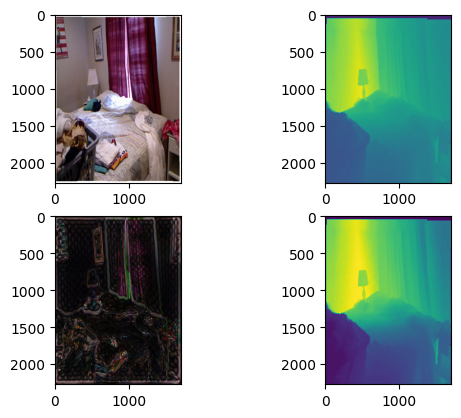

mean = 0.43471580743789673 : 0.5458502173423767
std = 0.2557029128074646 : 0.1991845965385437
min = 0.0 : 0.0
max = 1.0 : 1.0


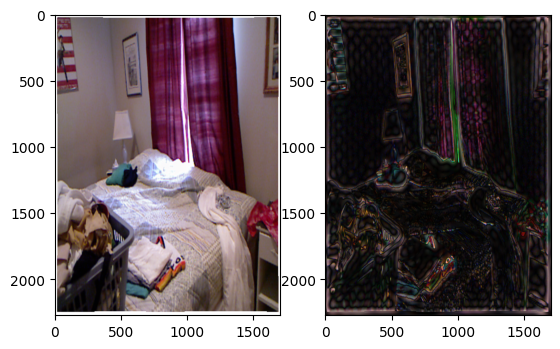

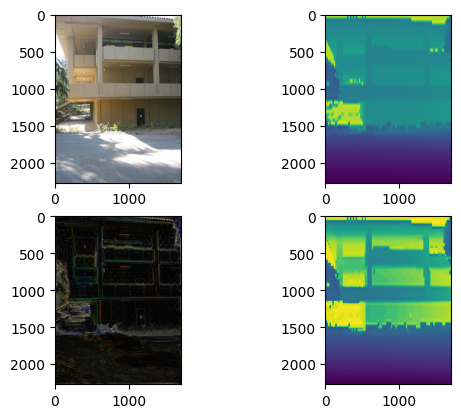

mean = 0.4826827645301819 : 0.3847771883010864
std = 0.22127342224121094 : 0.21407008171081543
min = 0.0 : 0.0
max = 1.0 : 0.9960784316062927


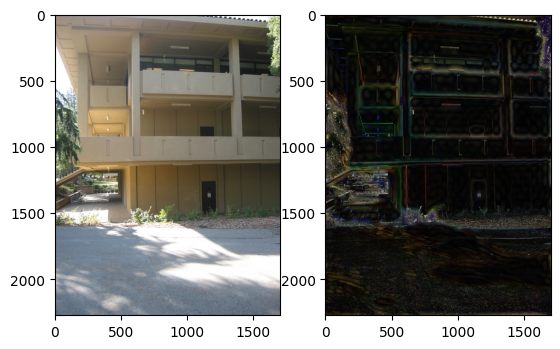

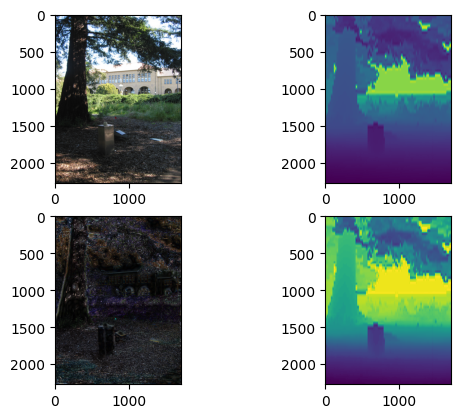

mean = 0.3256704807281494 : 0.2577187418937683
std = 0.28421029448509216 : 0.2146960198879242
min = 0.0 : 0.0
max = 1.0 : 1.0


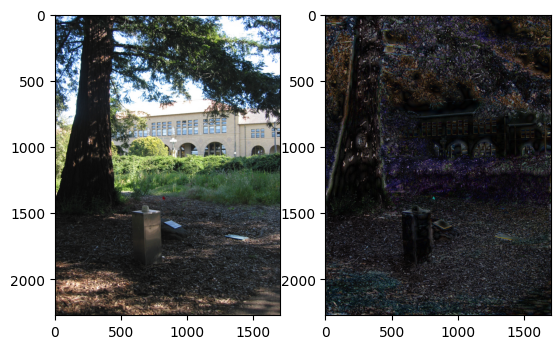

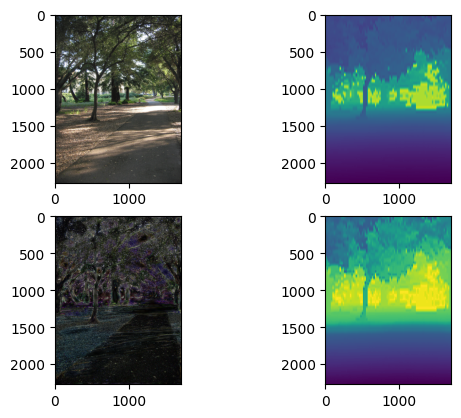

mean = 0.3082982897758484 : 0.3070332109928131
std = 0.20257095992565155 : 0.22442878782749176
min = 0.0 : 0.0
max = 1.0 : 1.0


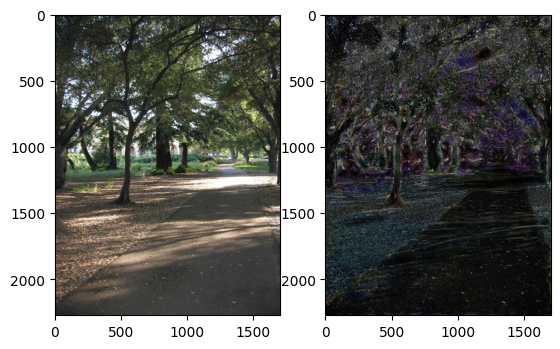

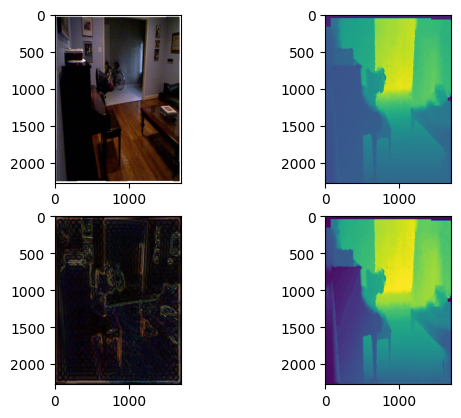

mean = 0.19991134107112885 : 0.49506258964538574
std = 0.22874689102172852 : 0.22185535728931427
min = 0.0 : 0.0
max = 1.0 : 1.0


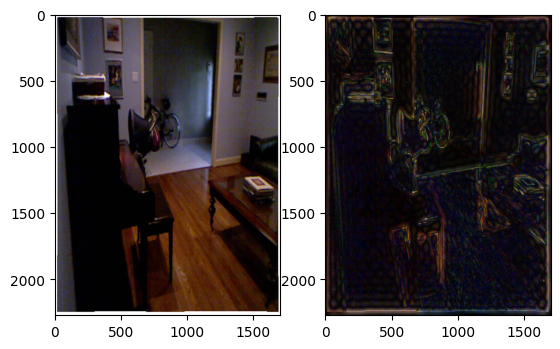

In [269]:

random.seed(time.time())
list = [i for i in range(800)]
indices = random.sample(list,5)
for index in indices:
    image,depth_map = concat_dataset[index]
    equalized_image = equalizeImage(image,fourier_amount=20)
    equalized_depth_map = equalizeDepth(depth_map)
    

    fig,axs = plt.subplots(2,2)
    image = image.cpu().permute(1,2,0).numpy()
    axs[0,0].imshow(image)
    axs[1,0].imshow(equalized_image.cpu().permute(1,2,0).numpy())
    
    depth_map = depth_map.cpu().permute(1,2,0).numpy()
    axs[0,1].imshow(depth_map)
    axs[1,1].imshow(equalized_depth_map.cpu().permute(1,2,0).numpy())

    plt.show()

    print(f"mean = {np.mean(image)} : {np.mean(depth_map)}")
    print(f"std = {np.std(image)} : {np.std(depth_map)}")
    print(f"min = {np.min(image)} : {np.min(depth_map)}")
    print(f"max = {np.max(image)} : {np.max(depth_map)}")
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(image)
    axs[1].imshow(equalized_image.cpu().permute(1,2,0).numpy())
    plt.show()
    


# AE Model

In [270]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder,self).__init__()
        #bias for skip
        self.bias4 = nn.Parameter(torch.ones(1))
        self.bias3 = nn.Parameter(torch.ones(1))
        self.bias2 = nn.Parameter(torch.ones(1))
        self.bias1 = nn.Parameter(torch.ones(1))

        self.relu4 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu1 = nn.ReLU()

        self.dropout4 = nn.Dropout2d(.1)
        self.dropout3 = nn.Dropout2d(.1)
        self.dropout2 = nn.Dropout2d(.1)
        self.dropout1 = nn.Dropout2d(.1)
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=12,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5,stride=2,padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=24,out_channels=36,kernel_size=7,stride=2,padding=1),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.encoder_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=36,out_channels=48,kernel_size=5,stride=2,padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.encoder_conv5 = nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        #decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=48,kernel_size=3,stride=1,padding=1),
            # nn.AdaptiveAvgPool2d((143, 107)),
            nn.BatchNorm2d(48),
            # nn.ReLU()
        )

        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48,out_channels=36,kernel_size=5,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((282,211)),
            nn.BatchNorm2d(36),
            # nn.ReLU()
        )

        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=36,out_channels=24,kernel_size=7,stride=2,padding=1),
            # nn.AdaptiveAvgPool2d((567,425)),
            nn.BatchNorm2d(24),
            # nn.ReLU()
        )

        self.decoder_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=24,out_channels=12,kernel_size=5,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((1136,852)),
            nn.BatchNorm2d(12),
            # nn.ReLU()
        )

        self.decoder_conv4_5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=12,out_channels=6,kernel_size=3,stride=1,padding=1),
            # nn.AdaptiveAvgPool2d((1136,852)),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.decoder_conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=6,out_channels=1,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((2272,1704)),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )


    def forward(self,x):
        encoder_x1 = self.encoder_conv1(x) #12
        encoder_x2 = self.encoder_conv2(encoder_x1) #24
        encoder_x3 = self.encoder_conv3(encoder_x2) #36
        encoder_x4 = self.encoder_conv4(encoder_x3) #48
        encoder_x5 = self.encoder_conv5(encoder_x4) #64

        x_d = self.decoder_conv1(encoder_x5)
        x_d = x_d + (encoder_x4 * self.bias4)
        x_d = self.relu4(x_d)
        x_d = self.dropout1(x_d)
        
        x_d = self.decoder_conv2(x_d)
        x_d = x_d + (encoder_x3 * self.bias3)
        x_d = self.relu3(x_d)
        x_d = self.dropout2(x_d)

        x_d = self.decoder_conv3(x_d)
        x_d = x_d = (encoder_x2 * self.bias2)
        x_d = self.relu2(x_d)
        x_d = self.dropout3(x_d)

        x_d = self.decoder_conv4(x_d)
        x_d = x_d + (encoder_x1 * self.bias1)
        x_d = self.relu1(x_d)
        x_d = self.dropout4(x_d)

        x_d = self.decoder_conv4_5(x_d)

        x_d = self.decoder_conv5(x_d)

        return x_d


In [236]:
encoder_decoder = EncoderDecoder()
encoder_decoder.to(device)
summary(encoder_decoder,(6,2272, 1704))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 12, 1136, 852]             660
       BatchNorm2d-2        [-1, 12, 1136, 852]              24
              ReLU-3        [-1, 12, 1136, 852]               0
         Dropout2d-4        [-1, 12, 1136, 852]               0
            Conv2d-5         [-1, 24, 567, 425]           7,224
       BatchNorm2d-6         [-1, 24, 567, 425]              48
              ReLU-7         [-1, 24, 567, 425]               0
         Dropout2d-8         [-1, 24, 567, 425]               0
            Conv2d-9         [-1, 36, 282, 211]          42,372
      BatchNorm2d-10         [-1, 36, 282, 211]              72
             ReLU-11         [-1, 36, 282, 211]               0
        Dropout2d-12         [-1, 36, 282, 211]               0
           Conv2d-13         [-1, 48, 140, 105]          43,248
      BatchNorm2d-14         [-1, 48, 1

In [237]:
del encoder_decoder

# Training

In [302]:
model = EncoderDecoder()
model.to(device)

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (dropout4): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (encoder_conv1): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

In [303]:
def save_check(epoch, model, optimizer, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f'Saved model at epoch:{epoch}')

In [304]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,gamma=0.5)

In [305]:
def l1_ssim_loss(input1,input2,bias=0.75):
    ssim_loss = piq.ssim(input1,input2,1.0)
    l1_loss = nn.L1Loss()(input1,input2)
    return (l1_loss * bias) + ((1-bias) * ssim_loss)

In [307]:
loss = l1_ssim_loss

In [308]:
def train(encoder_decoder,train_dataloader,optimizer, criterion, scheduler, epochs=2):
    for epoch in range(epochs):
        encoder_decoder.train()
        total_loss = 0.0
        batch_num = 0
        for data,depth_data in (train_dataloader):

            batch_num+=1
            
            inputs = data
            ground_truth = depth_data
            # ground_truth = (depth_data - depth_data.min()) / (depth_data.max() - depth_data.min())
            # print(np.shape(inputs))

            inputs = np.array([np.concatenate((img,equalizeImage(img,fourier_amount=20)),axis=0) for img in inputs])      

            ground_truth = np.array([equalizeDepth(depths) for depths in ground_truth])
            
            inputs = torch.from_numpy(inputs)
            ground_truth = torch.from_numpy(ground_truth)
            
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            optimizer.zero_grad()

            result = encoder_decoder(inputs)
            
            loss = criterion(result,ground_truth)

            loss.backward()

            optimizer.step()
            
            curr_loss = loss.item()
            total_loss+= curr_loss

            torch.cuda.empty_cache()
            print("Batch:{:3d}/{:3d}{:10}Loss{:10f}{:10}{:2d}/{:2d}".format(batch_num,len(train_dataloader),"",curr_loss,"",epoch,epochs))
        scheduler.step()
        filename ="./models/checkpoints"
        save_check(epoch,encoder_decoder,optimizer,criterion,f"{filename}/encoder_decoder_{epoch}.pth")

In [ ]:
train(model,concat_train_dataloader,optimizer,loss,scheduler,epochs=50)

In [ ]:
'''
model = EncoderDecoder()
state = torch.load("./models/checkpoints/encoder_decoder_19.pth",weights_only=False)
model.load_state_dict(state['model_state_dict'])
model.to(device)
'''


RuntimeError: Error(s) in loading state_dict for EncoderDecoder:
	size mismatch for encoder_conv1.0.weight: copying a param with shape torch.Size([12, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 6, 3, 3]).

In [ ]:
file_name = "default_v3_"
torch.save(model,f"./models/saved/{file_name}.pb")
torch.save(model.state_dict(),f"./models/saved/{file_name}_state.pth")

In [39]:
model.eval()

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (dropout4): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

In [40]:
from skimage.metrics import structural_similarity as ssim
def structuralSimilarityIndex(input1, input2):
    input1 = input1.squeeze().cpu().numpy()
    input2 = input2.squeeze().cpu().numpy()
    # print(input1.min())
    input1 = (input1 * 255).astype(np.uint8)
    input2 = (input2 * 255).astype(np.uint8)

    accuracy, diff_map = ssim(input1,input2,full=True)
    return accuracy, diff_map

    

In [41]:
def compareResults(model,dataloader, num_batches=3):
    i = 0
    for images, depths in dataloader:
        if i>=num_batches:
            break
        images = np.array([equalizeImage(img) for img in images])            
        depths = np.array([equalizeDepth(dpth) for dpth in depths])

        images = torch.from_numpy(images)
        depths = torch.from_numpy(depths)

        # print(images)
        with torch.no_grad():
            result = model(images.to(device))

            result = result.to("cpu")
            result = result.detach()
        for i in range(result.shape[0]):
            fig, axs = plt.subplots(1,4)
            axs[0].imshow(images[i].permute(1,2,0))

            axs[1].imshow(depths[i].permute(1,2,0))

            depth = np.array(result[i].permute(1,2,0)*255,dtype=np.uint8)
            
            axs[2].imshow(depth)

            
            print(f"mean:{np.mean(depth)}\nvar:{np.var(depth)}\nmax:{np.max(depth)}")
            # print(depths[i]-result[i])
            accuracy, diff_map = structuralSimilarityIndex(depths[i],result[i])
            print(f"accuracy:{accuracy}")
            axs[3].imshow(diff_map)
            
            plt.show()
        i+=1
        

mean:116.01521404689876
var:2743.066495073062
max:254
accuracy:0.19646797183728287


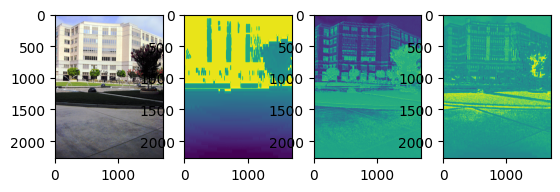

mean:152.94503147110362
var:528.6422843483865
max:253
accuracy:0.3466299499332401


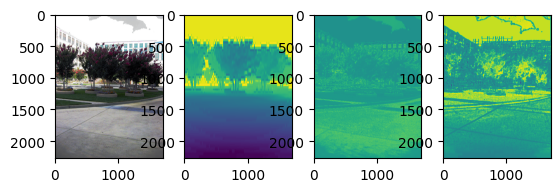

mean:109.62724513158764
var:2620.250030862891
max:253
accuracy:0.11273134510984276


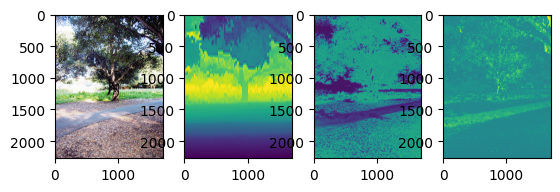

mean:122.51531814124182
var:3734.661253650518
max:254
accuracy:0.2069491892382395


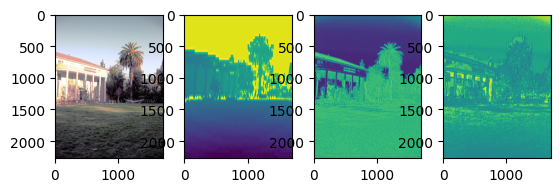

mean:128.24809659748396
var:3624.3741273313526
max:254
accuracy:0.0968567735472517


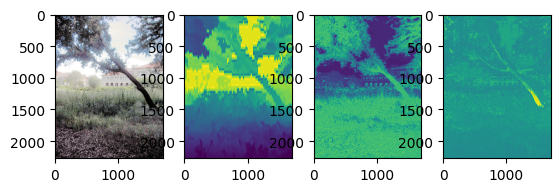

mean:127.61686798460954
var:2905.929681489329
max:254
accuracy:0.33359864779409826


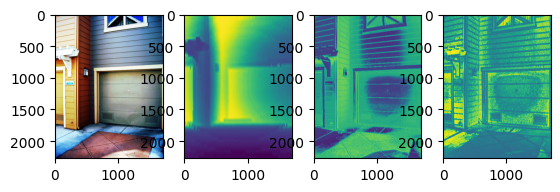

mean:138.55285254661774
var:2142.4536450629876
max:246
accuracy:0.23899171713195683


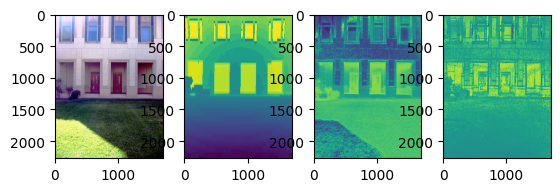

mean:141.76887878769094
var:2753.871118719282
max:251
accuracy:0.09369177582368504


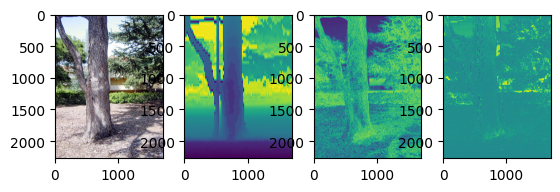

In [59]:
compareResults(model,val_dataloader,num_batches=2)

In [45]:
path = "./models/checkpoints/encoder_decoder_5.pth"
model2 = EncoderDecoder()
dict_load = torch.load(path,weights_only=False)
model2.load_state_dict(dict_load["model_state_dict"])
model2.to(device)

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (dropout4): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

mean:167.27634129306355
var:426.3061731600184
max:250
accuracy:0.35468504193003214


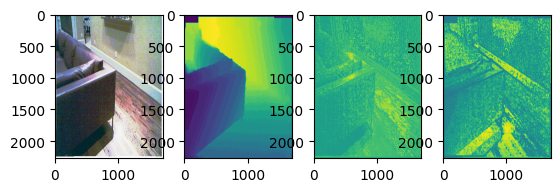

mean:161.12277475740595
var:358.90646376265005
max:231
accuracy:0.6642423135927499


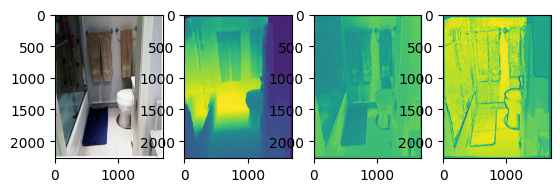

mean:126.72182711143623
var:3705.042904602792
max:254
accuracy:0.43030110722610904


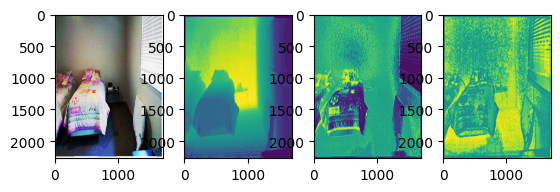

mean:110.61750701539046
var:2270.8110888852043
max:216
accuracy:0.5412651405858823


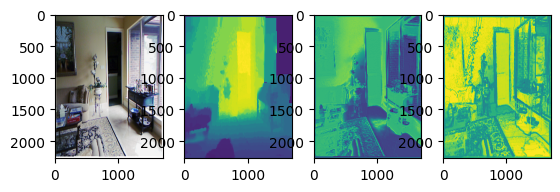

mean:121.04970905243668
var:3705.494414445366
max:230
accuracy:0.3519789911612826


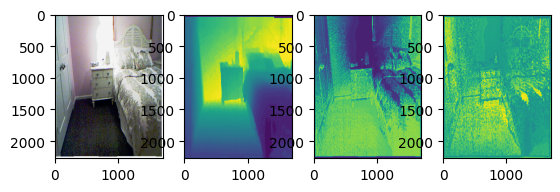

mean:122.0950071393738
var:2823.8169679381676
max:253
accuracy:0.3402889554027147


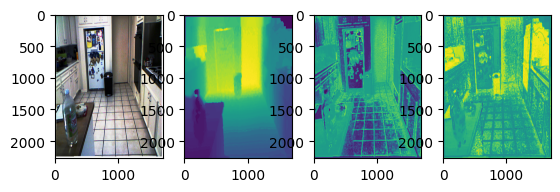

mean:118.79940451836606
var:2207.7426932350504
max:244
accuracy:0.3279604520242552


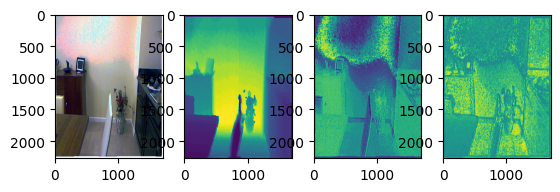

mean:116.57516825571976
var:2463.2431414123935
max:239
accuracy:0.33119685728970394


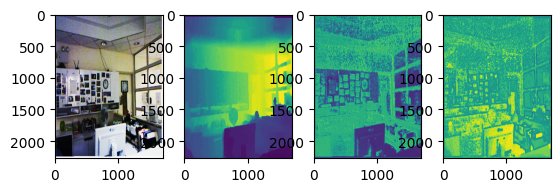

In [60]:
compareResults(model,test_nyu_dataloader,num_batches=2)

In [47]:
del model2

# Loading another data set*
*may not be completed

In [ ]:
model = EncoderDecoder()
model.to(device)

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (dropout4): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,gamma=0.5)

In [115]:
loss = l1_ssim_loss

In [ ]:
train(model,concat_train_dataloader,val_dataloader,optimizer,loss,scheduler,epochs=25)

Batch:  1/100          Loss  0.416384           0/25
Batch:  2/100          Loss  0.416388           0/25
Batch:  3/100          Loss  0.415045           0/25
Batch:  4/100          Loss  0.408085           0/25
Batch:  5/100          Loss  0.410089           0/25
Batch:  6/100          Loss  0.413555           0/25
Batch:  7/100          Loss  0.422614           0/25
Batch:  8/100          Loss  0.422775           0/25
Batch:  9/100          Loss  0.400471           0/25
Batch: 10/100          Loss  0.415809           0/25
Batch: 11/100          Loss  0.406327           0/25
Batch: 12/100          Loss  0.401508           0/25
Batch: 13/100          Loss  0.420672           0/25
Batch: 14/100          Loss  0.430722           0/25
Batch: 15/100          Loss  0.409119           0/25
Batch: 16/100          Loss  0.400766           0/25
Batch: 17/100          Loss  0.424483           0/25
Batch: 18/100          Loss  0.415460           0/25
Batch: 19/100          Loss  0.407644         

In [148]:
file_name = "concatenated"
torch.save(model,f"./models/saved/{file_name}.pb")
torch.save(model.state_dict(),f"./models/saved/{file_name}_state.pth")

In [154]:
model.eval()

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (dropout4): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

mean:133.60262488221582
var:1916.5254496476346
max:251
accuracy:0.12184573525312803


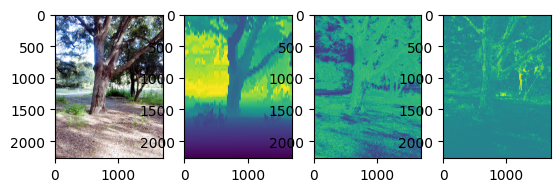

mean:130.67506343814057
var:1755.5116068303494
max:250
accuracy:0.19027513724966516


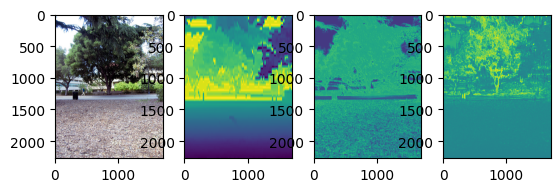

mean:124.45568499760299
var:1933.5785432104176
max:248
accuracy:0.2979860202207042


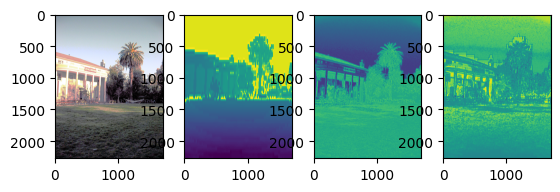

mean:136.9170014216756
var:1860.9729525786527
max:253
accuracy:0.07918906556798551


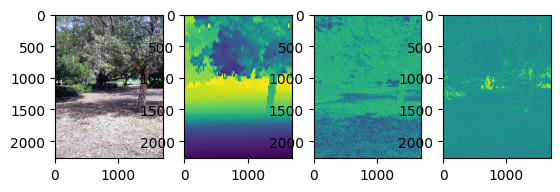

mean:128.2484902445778
var:2211.7998797039977
max:249
accuracy:0.37866988065464335


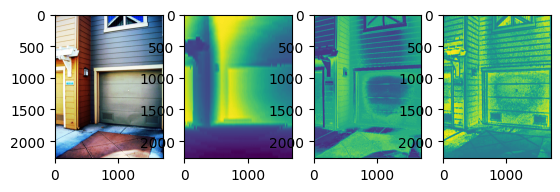

mean:130.12646042038617
var:1851.8662339242132
max:251
accuracy:0.3333078729366566


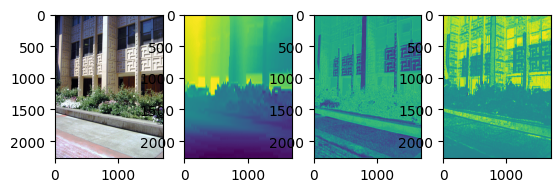

mean:132.25046028813728
var:1926.626784889885
max:251
accuracy:0.142369535795964


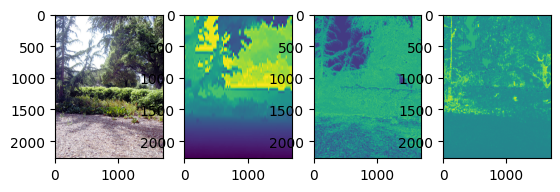

mean:133.86874969004165
var:1900.0817389218291
max:253
accuracy:0.15014058665589936


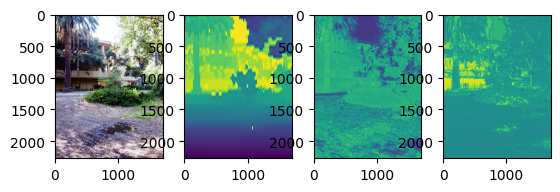

In [155]:
compareResults(model,val_dataloader,num_batches=2)